In [1]:
import urllib.request
import json
import numpy as np
import pandas as pd

In [2]:
data_url = 'https://raw.githubusercontent.com/KU81-ComSci-ProjectEnd-GameCard/main/master/Predictor/data/processed_data/quality_run8k.json'
json_data = list()
with urllib.request.urlopen(data_url) as url:
    run_js = json.loads(url.read().decode())
run = pd.DataFrame(run_js)

In [3]:
run.loc[ run.master_deck.apply(len) > 50].count().count()
### only 51 run from 8k that have deck len > 50 mark as noise

51

In [4]:
rows_to_drop = run[run.master_deck.apply(len) > 50].index
run = run.drop(rows_to_drop)

In [5]:
decks = run.master_deck.tolist()

In [6]:
def upgrade_lst(lst):
  new_lst = list()
  for item in lst:
    if(item != 'Searing Blow'):
      new_lst.append(item+'+1')
  return new_lst
    
def get_ALL_CARD():
  IC_ATTACK_CARDS = ["Strike_R", "Bash", "Anger", "Body Slam", "Clash", "Cleave", "Clothesline", "Headbutt", "Heavy Blade", "Iron Wave", "Perfected Strike", "Pommel Strike", "Sword Boomerang", "Thunderclap", "Twin Strike", "Wild Strike", "Blood for Blood", "Carnage", "Dropkick", "Hemokinesis", "Pummel", "Rampage", "Reckless Charge", "Searing Blow", "Sever Soul", "Uppercut", "Whirlwind", "Bludgeon", "Feed", "Fiend Fire", "Immolate", "Reaper"]
  IC_SKILL_CARDS = ["Defend_R", "Armaments", "Flex", "Havoc", "Shrug It Off", "True Grit", "Warcry", "Battle Trance", "Bloodletting", "Burning Pact", "Disarm", "Dual Wield", "Entrench", "Flame Barrier", "Ghostly Armor", "Infernal Blade", "Intimidate", "Power Through", "Rage", "Second Wind", "Seeing Red", "Sentinel", "Shockwave", "Spot Weakness", "Double Tap", "Exhume", "Impervious", "Limit Break", "Offering"]
  IC_POWER_CARDS = ["Combust", "Dark Embrace", "Evolve", "Feel No Pain", "Fire Breathing", "Inflame", "Metallicize", "Rupture", "Barricade", "Berserk", "Brutality", "Corruption", "Demon Form", "Juggernaut"]
  IRONCLAD_CARDS = IC_ATTACK_CARDS + IC_SKILL_CARDS + IC_POWER_CARDS

  COLORLESS_CARDS = ["Dramatic Entrance", "Flash of Steel", "Mind Blast", "Swift Strike", "HandOfGreed", "Bite", "Expunger", "Ritual Dagger", "Shiv", "Smite", "Through Violence", "Bandage Up", "Blind", "Dark Shackles", "Deep Breath", "Discovery", "Enlightenment", "Finesse", "Forethought", "Good Instincts", "Impatience", "Jack Of All Trades", "Madness", "Panacea", "PanicButton", "Purity", "Trip", "Apotheosis", "Chrysalis", "Master of Strategy", "Metamorphosis", "Secret Technique", "Secret Weapon", "The Bomb", "Thinking Ahead", "Transmutation", "Violence", "Apparition", "Beta", "Insight", "J.A.X.", "Miracle", "Safety", "Magnetism", "Mayhem", "Panache", "Sadistic Nature", ]

  CURSE_CARDS = ["AscendersBane", "Clumsy", "Curse of the Bell", "Decay", "Doubt", "Injury", "Necronomicurse", "Normality", "Pain", "Parasite", "Pride", "Regret", "Shame", "Writhe"]
  return IRONCLAD_CARDS + COLORLESS_CARDS + CURSE_CARDS + upgrade_lst(IRONCLAD_CARDS) + upgrade_lst(COLORLESS_CARDS)

vocab = get_ALL_CARD()

In [7]:
from keras.preprocessing.sequence import pad_sequences

value_to_index = dict( zip(vocab , range(0,len(vocab))))
index_to_value = dict( zip(range(0,len(vocab)),vocab ))

deck_indices = [[value_to_index[c] for c in deck] for deck in decks]
max_len = max(len(lst) for lst in deck_indices)
deck_indices_padded = pad_sequences(deck_indices, maxlen=max_len)
x = deck_indices_padded

In [8]:
x.shape

(7978, 50)

In [9]:
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [10]:
def custom_analyzer(doc):
    return doc
deckVecorizer = load('matrix_data/deckVectorizer_8k_30K.joblib')

In [11]:
y = deckVecorizer.fit_transform(decks)
n_components = 20 # Number of dimensions to reduce to
svd = TruncatedSVD(n_components=n_components)
y = svd.fit_transform(y)

In [12]:
vocab_size = len(vocab)  # Size of the vocabulary
embedding_dim = 20  # Size of the embedding vectors
input_length = 50  # Length of each input sequence
output_dim = 20

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense,Input

In [14]:
from keras.callbacks import Callback
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            loss = logs.get("loss", "N/A")
            acc = logs.get("accuracy", "N/A")
            val_loss = logs.get("val_loss", "N/A")
            val_acc = logs.get("val_accuracy", "N/A")
            print(f'Epoch {epoch + 1}: loss = {loss:.4f}, acc = {acc:.4f}, val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}')

epoch_logger = EpochLogger()

In [15]:
model = Sequential([
    Input(shape=(input_length ,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Flatten(),
    Dense(output_dim,trainable=False)  
])

In [16]:
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

In [17]:
# Train the model
model.fit(x, y, epochs=15, batch_size=32, validation_split=0.2 ,verbose=1)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6744 - loss: 0.0863 - val_accuracy: 0.8421 - val_loss: 0.0603
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8609 - loss: 0.0532 - val_accuracy: 0.8822 - val_loss: 0.0434
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.8725 - loss: 0.0380 - val_accuracy: 0.9066 - val_loss: 0.0339
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.8978 - loss: 0.0307 - val_accuracy: 0.9173 - val_loss: 0.0308
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.9111 - loss: 0.0275 - val_accuracy: 0.9123 - val_loss: 0.0286
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8985 - loss: 0.0259 - val_accuracy: 0.9135 - val_loss: 0.0274
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.9096 - loss: 0.0254 - val_accuracy: 0.9261 - val_loss: 0.0272
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9140 - loss: 0.0246 - val_ac

In [18]:
embedding_layer = model.get_layer(index=0) 
embedding_weights = embedding_layer.get_weights()[0]

In [19]:
embedding_weights.shape

(257, 20)

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

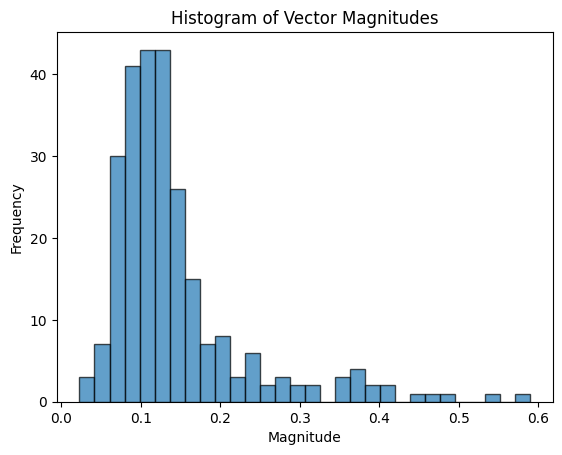

In [21]:
magnitudes = np.linalg.norm(embedding_weights, axis=1)

# Plot histogram of magnitudes
plt.hist(magnitudes, bins='auto', edgecolor='black', alpha=0.7)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Vector Magnitudes')
plt.show()

In [22]:
card_vectors = dict( zip(vocab,embedding_weights))

In [23]:
from joblib import dump
import os

In [24]:
save_path = os.path.join('matrix_data', 'cardVecSuper_8k_20dim.joblib')

In [25]:
dump(card_vectors, save_path)

['matrix_data\\cardVecSuper_8k_20dim.joblib']

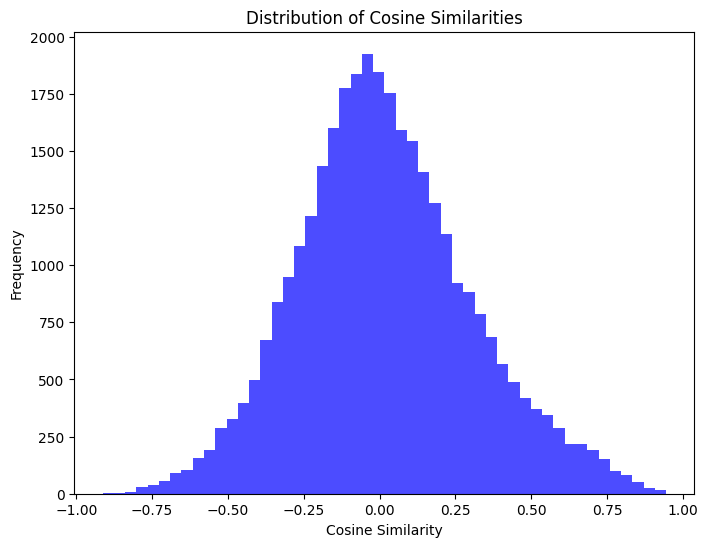

In [26]:
cosine_sim_matrix = cosine_similarity(embedding_weights)
cosine_sim_values = cosine_sim_matrix[np.triu_indices_from(cosine_sim_matrix, k=1)]

# Plot the distribution of cosine similarities
plt.figure(figsize=(8, 6))
plt.hist(cosine_sim_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [27]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [29]:
cardKmean = KMeans(n_clusters=10, random_state=10,n_init= 50)
cardK = cardKmean.fit_predict(embedding_weights)

In [30]:
from collections import Counter
Counter(cardK)

Counter({0: 89, 8: 66, 2: 62, 6: 27, 5: 7, 1: 2, 4: 1, 9: 1, 7: 1, 3: 1})

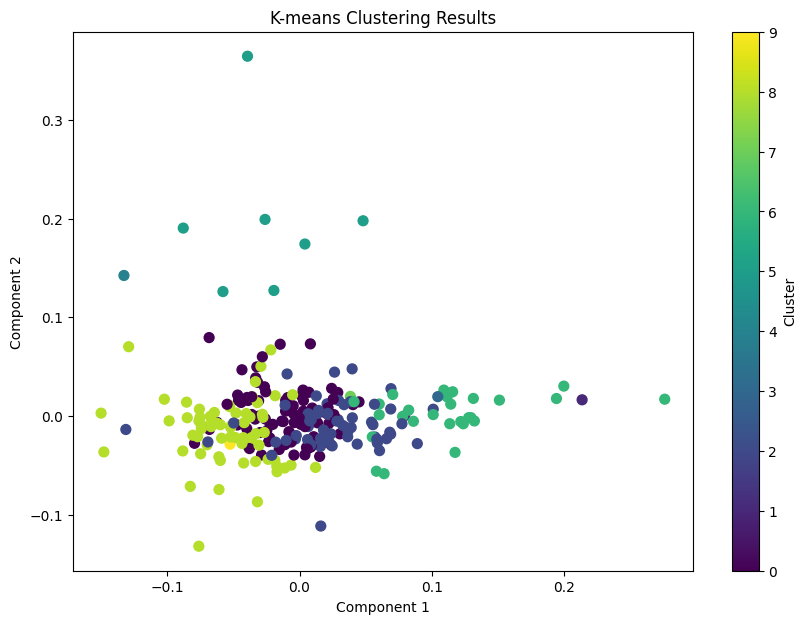

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Assuming cardVect is a numpy array with shape (257, 20)
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_weights)

plot_data = pca_result

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(plot_data[:, 0], plot_data[:, 1], c=cardK, cmap='viridis', marker='o', s=50)
plt.colorbar(label='Cluster')
plt.title('K-means Clustering Results')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

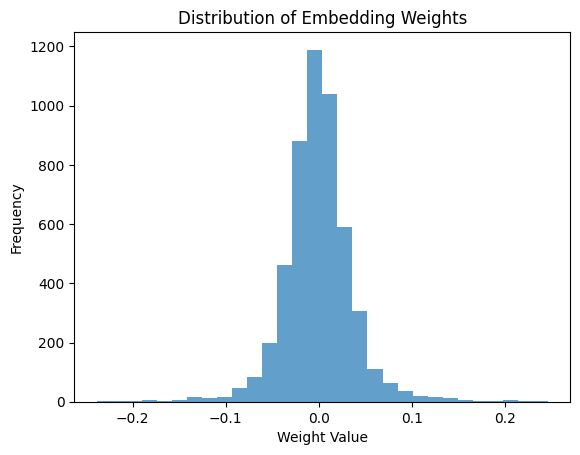

In [32]:
plt.hist(embedding_weights.flatten(), bins=30, alpha=0.7)
plt.title('Distribution of Embedding Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()

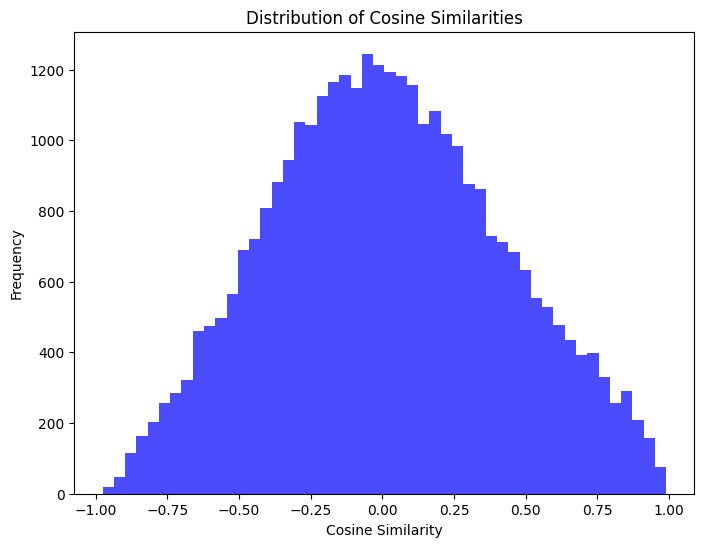

In [34]:

cosine_sim_matrix2 = cosine_similarity(cosine_sim_matrix)

cosine_sim_values = cosine_sim_matrix2[np.triu_indices_from(cosine_sim_matrix2, k=1)]

# Plot the distribution of cosine similarities
plt.figure(figsize=(8, 6))
plt.hist(cosine_sim_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()